In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
import re
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Descargar stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))


[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [25]:
# Configuración de rutas
folder_path = 'C:/Users/carlo/Documents/Laptop Gris/RESPALDO MEMORIA COSA CARLOS/Tecnologico Universidad/Semestre 7 Tec morelia/Taller De Investigacion II/Modelos y datos/Modelo en python'
model_filename = 'modelo_entrenado.pkl'
vectorizer_filename = 'vectorizer.pkl'
processed_files = set()

# Crear carpeta para modelos si no existe
os.makedirs(folder_path, exist_ok=True)

# Función para cargar datos
def load_data(file_path):
    if os.path.exists(file_path):
        return pd.read_csv(file_path)
    else:
        print(f"No se encontró el archivo: {file_path}")
        return None


In [27]:
# Cargar datos
df = load_data(os.path.join(folder_path, 'emails.csv'))
if df is not None:
    print(df.head())
else:
    print("No se pudo cargar el DataFrame.")


                                          email_text  label
0  Hola, notamos actividad inusual en tu cuenta. ...      1
1  Recordatorio: Tu suscripción está a punto de v...      1
2        Hola, ¿podemos vernos para almorzar mañana?      0
3  ¡Felicidades! Has ganado una tarjeta de regalo...      1
4  Estimado cliente, su compra reciente se proces...      0


In [29]:
# Limpieza de texto
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Aplicar limpieza de texto
df['cleaned_text'] = df['email_text'].apply(clean_text)


In [31]:
# Dividir los datos en entrenamiento y prueba
X = df['cleaned_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [33]:
# Intentar cargar el modelo y el vectorizador si existen
model_path = os.path.join(folder_path, model_filename)
vectorizer_path = os.path.join(folder_path, vectorizer_filename)

if os.path.exists(model_path) and os.path.exists(vectorizer_path):
    # Cargar modelo y vectorizador
    model = joblib.load(model_path)
    vectorizer = joblib.load(vectorizer_path)
    print("Modelo y vectorizador cargados exitosamente.")
else:
    # Vectorización con TF-IDF
    vectorizer = TfidfVectorizer(max_features=1000)
    X_train_tfidf = vectorizer.fit_transform(X_train)

    # Entrenar modelo Naive Bayes
    model = MultinomialNB()
    model.fit(X_train_tfidf, y_train)

    # Guardar el modelo y el vectorizador
    joblib.dump(model, model_path)
    joblib.dump(vectorizer, vectorizer_path)
    print("Modelo y vectorizador entrenados y guardados.")


Modelo y vectorizador cargados exitosamente.


C:\Users\carlo\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MultinomialNB from version 1.5.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\carlo\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.5.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\carlo\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.5.2 when using version 1.5.1. This might lead to breaki

In [35]:
# Evaluación del modelo
X_test_tfidf = vectorizer.transform(X_test)
y_pred = model.predict(X_test_tfidf)

# Imprimir resultados
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8461538461538461
Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.83      0.83      0.83         6

    accuracy                           0.85        13
   macro avg       0.85      0.85      0.85        13
weighted avg       0.85      0.85      0.85        13



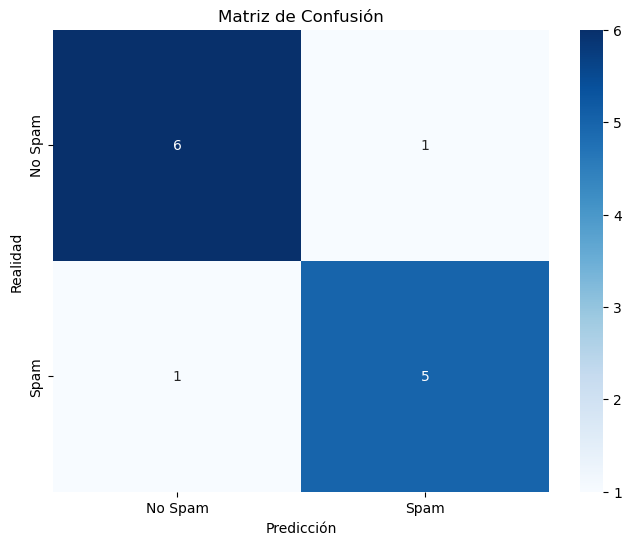

In [37]:
# Visualización de la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Spam', 'Spam'], yticklabels=['No Spam', 'Spam'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()


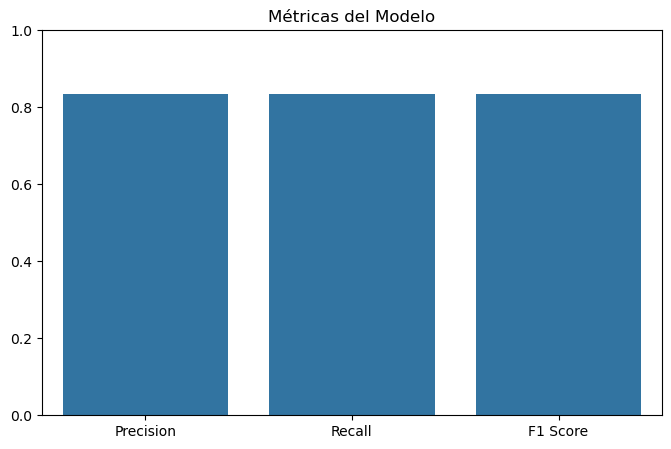

In [39]:
# Visualización de las métricas de rendimiento
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

labels = ['Precision', 'Recall', 'F1 Score']
scores = [precision, recall, fscore]

plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=scores)
plt.title('Métricas del Modelo')
plt.ylim(0, 1)
plt.show()


In [19]:
# Manejo de nuevos correos electrónicos
for filename in os.listdir(folder_path):
    if filename.endswith('.csv') and filename not in processed_files and filename != 'emails.csv':
        nuevos_email_path = os.path.join(folder_path, filename)
        nuevos_emails = load_data(nuevos_email_path)

        if nuevos_emails is not None:
            nuevos_emails['cleaned_text'] = nuevos_emails['email_text'].apply(clean_text)

            # Transformar nuevos correos
            X_nuevos_tfidf = vectorizer.transform(nuevos_emails['cleaned_text'])

            # Predecir nuevos correos
            nuevos_predicciones = model.predict(X_nuevos_tfidf)
            nuevos_emails['predicciones'] = nuevos_predicciones

            print(f"Predicciones para el archivo {filename}:")
            print(nuevos_emails[['email_text', 'predicciones']])
            
            # Añadir archivo a la lista de procesados
            processed_files.add(filename)
